# Lugge glacier 1D

This notebook uses the RGI centerline to mesh Lugge in 1D, then interpolates several datasets onto that mesh. 

## Imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from firedrake import Function, FunctionSpace, IntervalMesh
import pandas as pd
from pyproj import Geod
from scipy.interpolate import interp1d

## Set paths and load data

In [2]:
# Paths
base_path = '/eejit/home/bezu0001/'
centerline_path = base_path + 'data/centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'data/outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'

# Load data
centerlines = gpd.read_file(centerline_path)
outlines = gpd.read_file(outline_path)
lugge_outline = outlines[outlines['rgi_id'].str.contains("15-09534")].geometry.values[0]
lugge_centerline = centerlines[centerlines.intersects(lugge_outline)].geometry.values[0]

## Create interval mesh of the correct spatial length

In [3]:
# Compute total geodesic length
geod = Geod(ellps="WGS84")
x, y = lugge_centerline.xy
distances = [0] + [geod.inv(x[i], y[i], x[i+1], y[i+1])[2] for i in range(len(x)-1)]
length = np.sum(distances)

# Create a Firedrake IntervalMesh with the correct length
n_cells = 1000  # Adjust as needed
mesh = IntervalMesh(n_cells, length)

print(f"Created 1D IntervalMesh of length {length:.2f} m with {n_cells} cells.")

Created 1D IntervalMesh of length 8594.88 m with 1000 cells.


## Interpolate surface elevations

In [4]:
# Open DEM and sample values
with rasterio.open(base_path + 'data/elevation/DEM-SRTMv3/SRTMv3_RGI60-15-02373.tif') as src:
    dem_values = np.array(list(src.sample(zip(x, y)))).flatten()

# Compute cumulative distances
distances = np.insert(np.cumsum([Geod(ellps="WGS84").inv(x[i], y[i], x[i+1], y[i+1])[2] for i in range(len(x)-1)]), 0, 0)

# Interpolate DEM values onto mesh vertices
vertex_coords = mesh.coordinates.dat.data_ro.flatten()
dem_interpolated = interp1d(distances, dem_values, bounds_error=False, fill_value='extrapolate')(vertex_coords)

# Create Function for DEM
dem = Function(FunctionSpace(mesh, 'CG', 1))
dem.dat.data[:] = dem_interpolated

## Thickness

In [5]:
# Sample thickness values at centerline
with rasterio.open(base_path + 'data/bed/Thickness-Farinotti/RGI60-15-02373_latlon.tif') as src:
    thickness_values = np.array(list(src.sample(zip(x, y)))).flatten()

# Interpolate thickness onto mesh vertices
thickness_interpolated = interp1d(distances, thickness_values, bounds_error=False, fill_value='extrapolate')(vertex_coords)

# Create Function for thickness
thickness = Function(FunctionSpace(mesh, "CG", 1))
thickness.dat.data[:] = thickness_interpolated

## Surface mass balance

In [6]:
# Load SMB CSV data
smb_data = pd.read_csv(base_path + 'data/smb/prf_glacier_ctl.csv')
altitudes = smb_data[' altitude'].values
smb_values = smb_data['ave_mb'].values

# Interpolation function: altitude vs SMB
smb_interp = interp1d(altitudes, smb_values, bounds_error=False, fill_value='extrapolate')

# Interpolate SMB onto mesh vertices based on vertex elevations
vertex_elevations = dem.dat.data_ro
smb_on_mesh = smb_interp(vertex_elevations)
smb = Function(FunctionSpace(mesh, "CG", 1))
smb.dat.data[:] = smb_on_mesh

## And plot

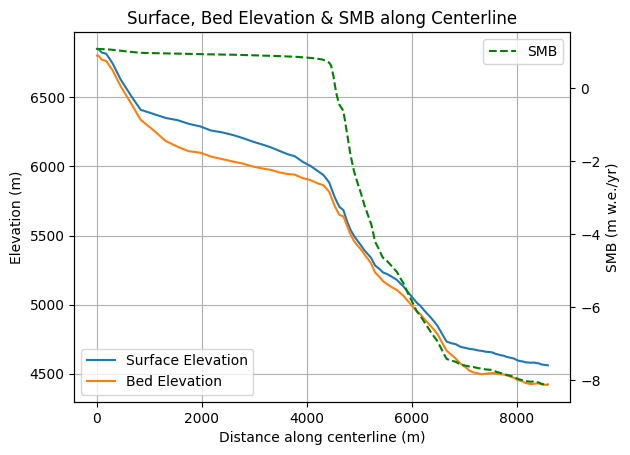

In [7]:
# Sample elevation, thickness, and SMB along the mesh
X = np.array([(x,) for x in np.linspace(0, length, int(length))])
elevation_profile = np.array(dem.at(X, tolerance=1e-10))
thickness_profile = np.array(thickness.at(X, tolerance=1e-10))
bed_profile = elevation_profile - thickness_profile
smb_profile = np.array(smb.at(X, tolerance=1e-10))

# Plot
fig, ax1 = plt.subplots()
ax1.plot(X.flatten(), elevation_profile, label='Surface Elevation')
ax1.plot(X.flatten(), bed_profile, label='Bed Elevation')
ax1.set_xlabel('Distance along centerline (m)')
ax1.set_ylabel('Elevation (m)')
ax1.grid(True)
ax1.legend(loc='lower left')

# Add twin axis for SMB
ax2 = ax1.twinx()
ax2.plot(X.flatten(), smb_profile, color='green', linestyle='dashed', label='SMB')
ax2.set_ylabel('SMB (m w.e./yr)')
ax2.legend(loc='upper right')

plt.title('Surface, Bed Elevation & SMB along Centerline')
plt.show()